In [1]:
import argparse
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from bts.models.data import Data, Sample
from bts.models.regression import BaseLineModel, SwitchPointBasicModel, SwitchPointModel, SwitchPointDiscreteModel, GaussianProcessModel
from bts.models.clustering import DirchletProcessModel, GaussianMixtureModel, TMixtureModel

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

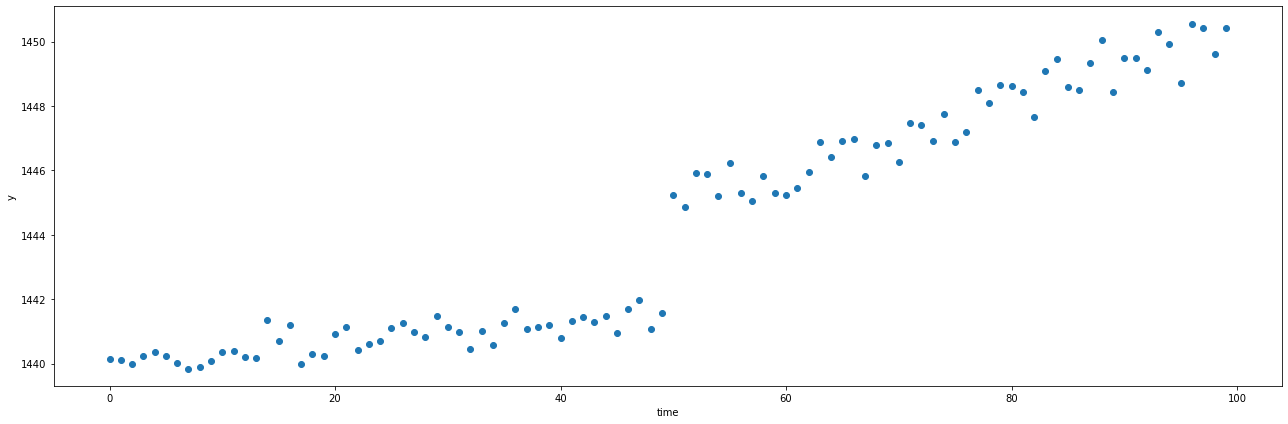

In [12]:
sample = (
    Sample(N=50, mu=1440, beta=0.03, sigma=0.3) 
    + Sample(N=50, mu=1445, beta=0.1, sigma=0.6)
)
sample.plot()
sample_data = [sample.y, sample.t, sample.dt]

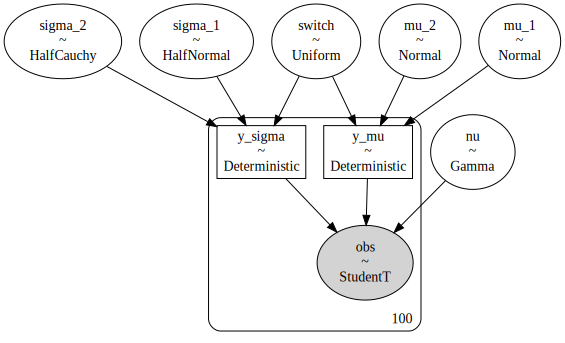

In [4]:
model = SwitchPointBasicModel(*sample_data)
model.define_model() 
pm.model_to_graphviz(model.model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, mu_2, mu_1, switch]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.


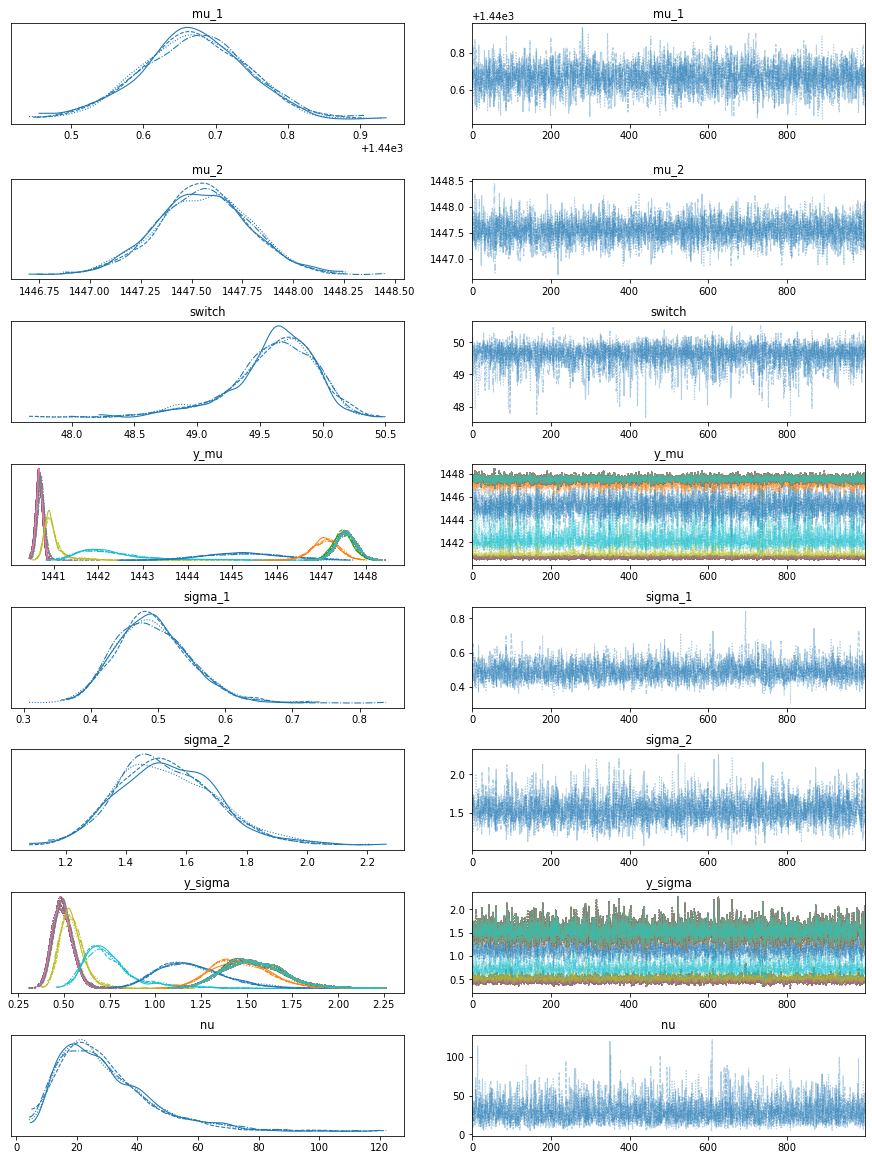

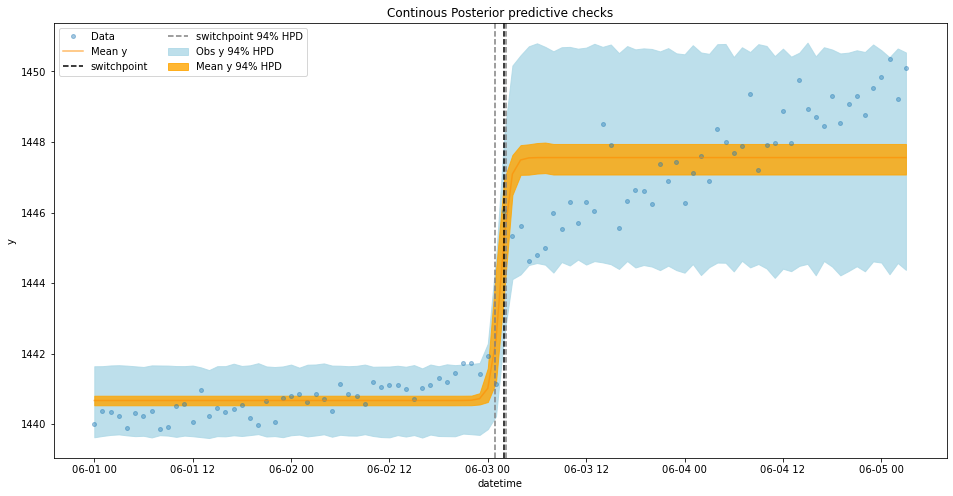

In [7]:
model.fit()
model.plot_trace()
model.plot_posterior_predictive()

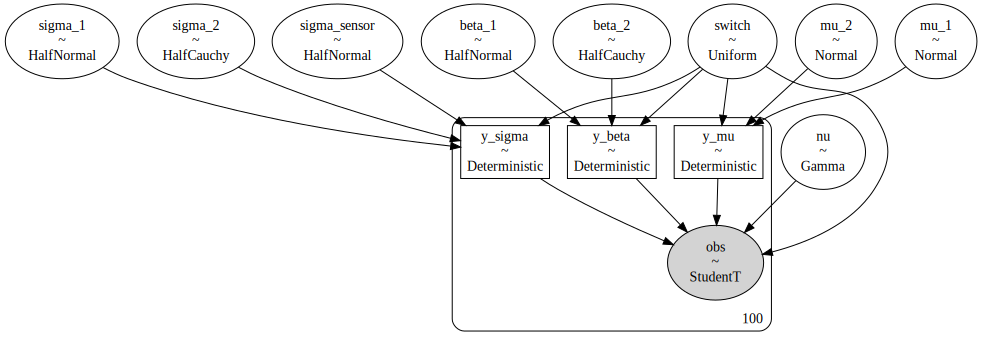

In [12]:
sp_model = SwitchPointModel(*sample_data)
sp_model.define_model() 
pm.model_to_graphviz(sp_model.model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_2, sigma_1, sigma_sensor, beta_2, beta_1, mu_2, mu_1, switch]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 33 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


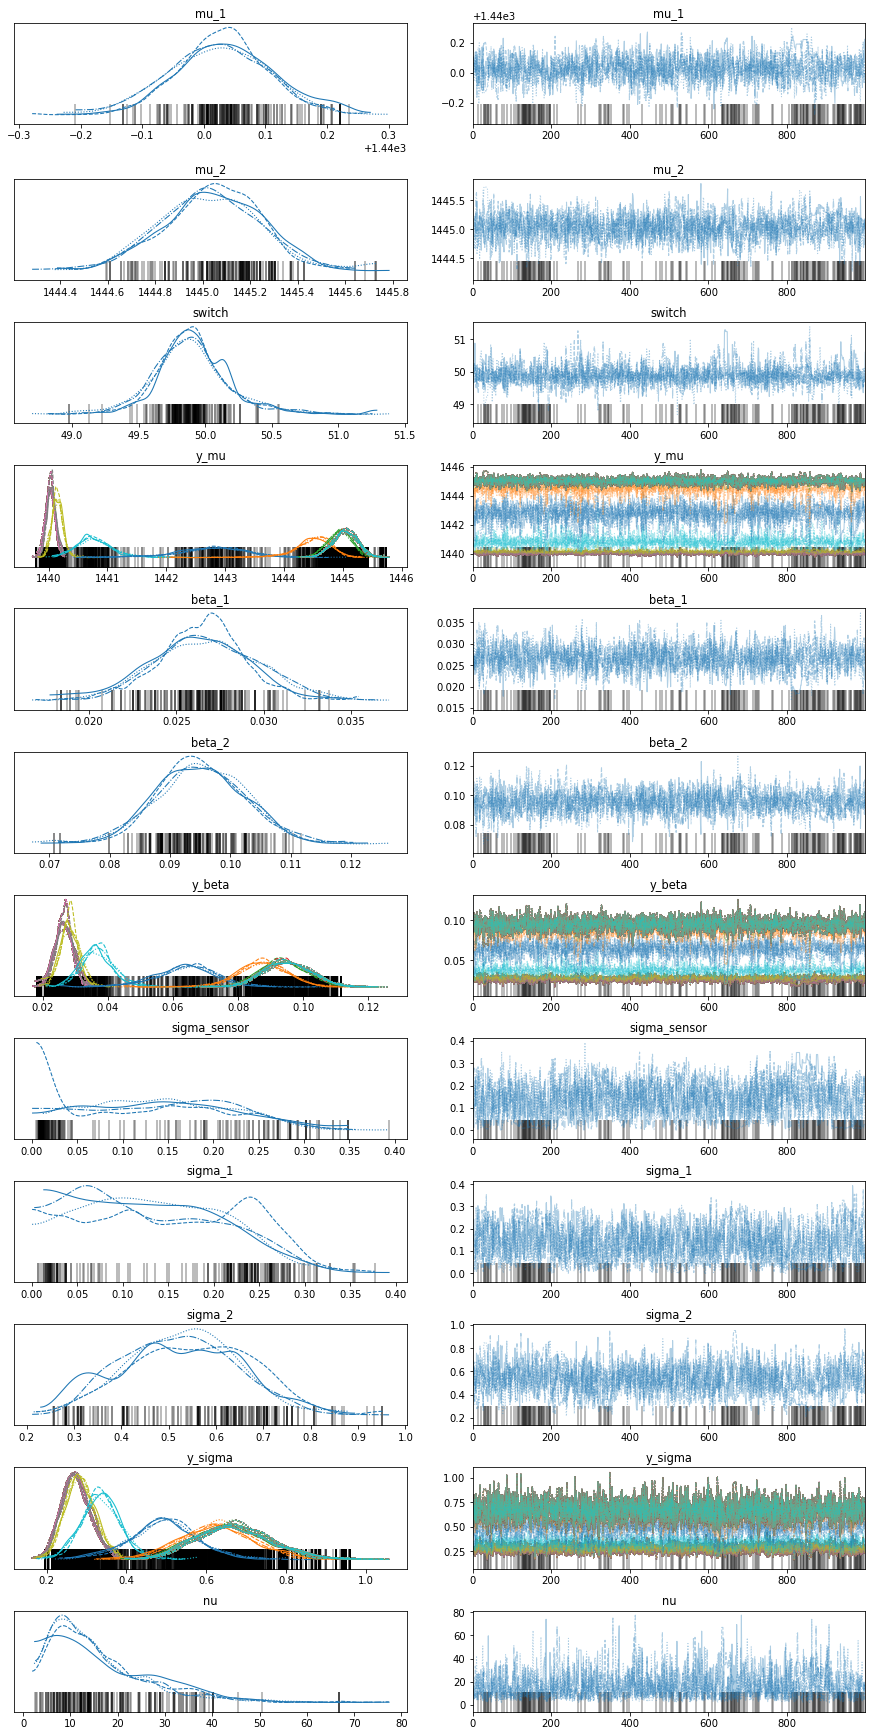

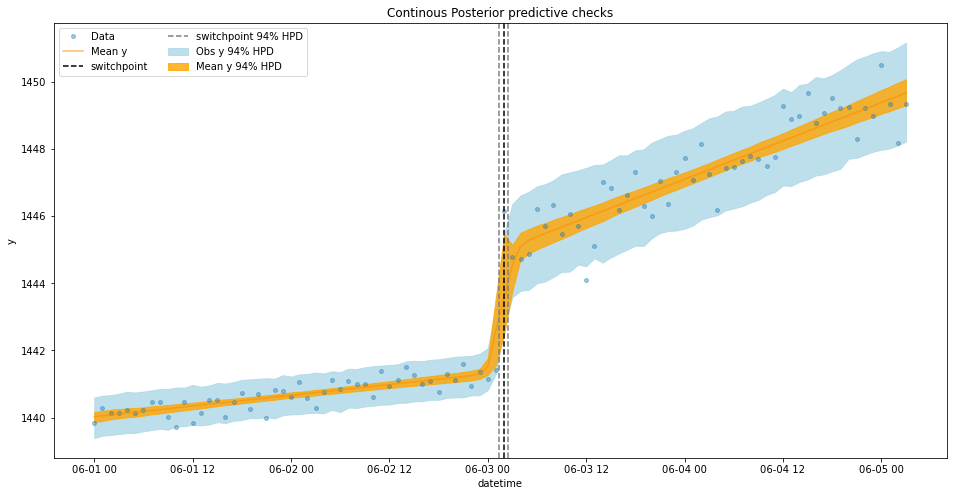

In [16]:
sp_model.fit()
sp_model.plot_trace()
sp_model.plot_posterior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma_, y_beta, y_mu]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


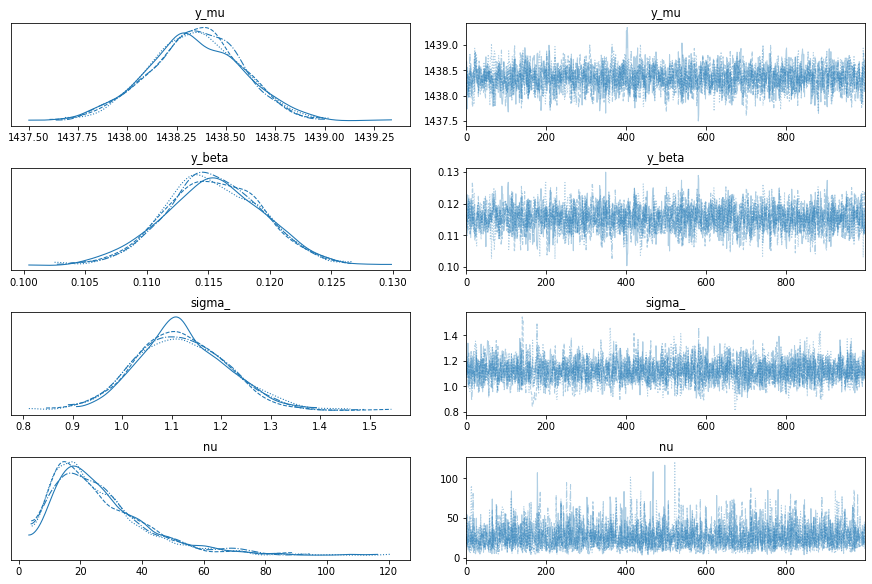

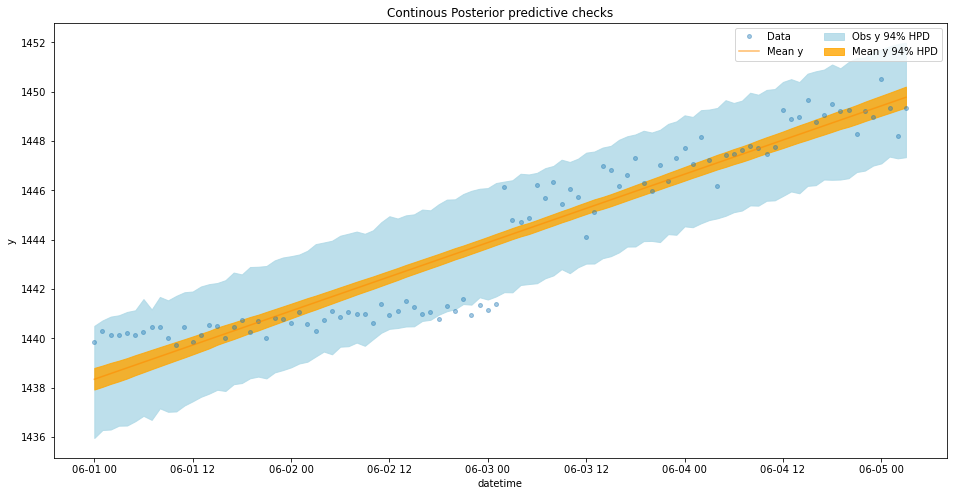

In [17]:
bl_model = BaseLineModel(*sample_data)
bl_model.define_model() 
bl_model.fit()
bl_model.plot_trace()
bl_model.plot_posterior_predictive()

In [20]:
def select_model(p=0.6):
    comparison = az.compare({"switchpoint": sp_model.trace, "baseline": bl_model.trace})
    stats = ['rank', 'weight', 'loo', 'd_loo']
    comp = comparison[stats]
    
    chosen_model_idx = 0 if comp.iloc[0]['weight']>p else 1
    chosen_model = comp.index[chosen_model_idx]
    return chosen_model, comp

chosen_model, comp = select_model()
print(f'chosen model: {chosen_model}')
comp

C:\Users\benyp\anaconda3\envs\pm\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


chosen model: switchpoint


C:\Users\benyp\anaconda3\envs\pm\lib\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    weight         loo      d_loo
switchpoint     0  0.971818  -72.991731   0.000000
baseline        1  0.028182 -158.430899  85.439168

In [21]:
def get_params():
    params = ['mu_1', 'mu_2', 'beta_1', 'beta_2', 'sigma_1', 'sigma_2', 'sigma_sensor']
    stats = ['mean']#, 'sd']
    summary = az.summary(sp_model.trace)
    summ = summary[stats].T[params]
    return summ

get_params()

mu_1      mu_2  beta_1  beta_2  sigma_1  sigma_2  sigma_sensor
mean  1440.028  1445.037   0.027   0.095    0.136    0.533         0.139

# Gaussian Process for forecasting (Didn't wrap it up, just for demonstration)

In [22]:
y=sample.y
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean)/y_std
X=sample.t[:, None]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_, η, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 334 seconds.
The number of effective samples is smaller than 25% for some parameters.


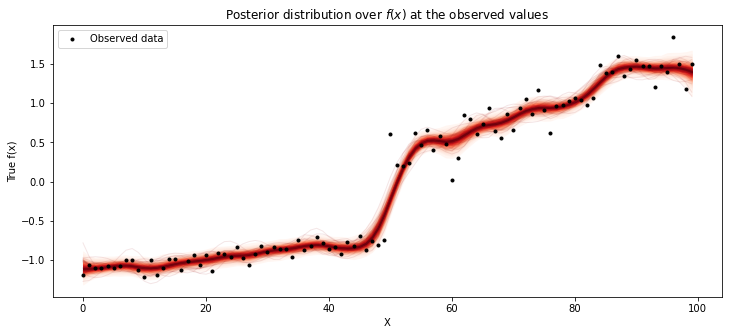

In [23]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=1)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0 / σ, nu=ν, observed=y)

    trace = pm.sample(1000, chains=2, cores=1, return_inferencedata=True)

# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["f"][0, :, :], X)

# plot the data
ax.plot(X, y, "ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

# Kalman Filter for retriving actual value (sensor readings are usually not the actual value)

In [29]:
from bts.models.data import gaussian
from bts.models.kalman_filter import KalmanFilterChangePointModel

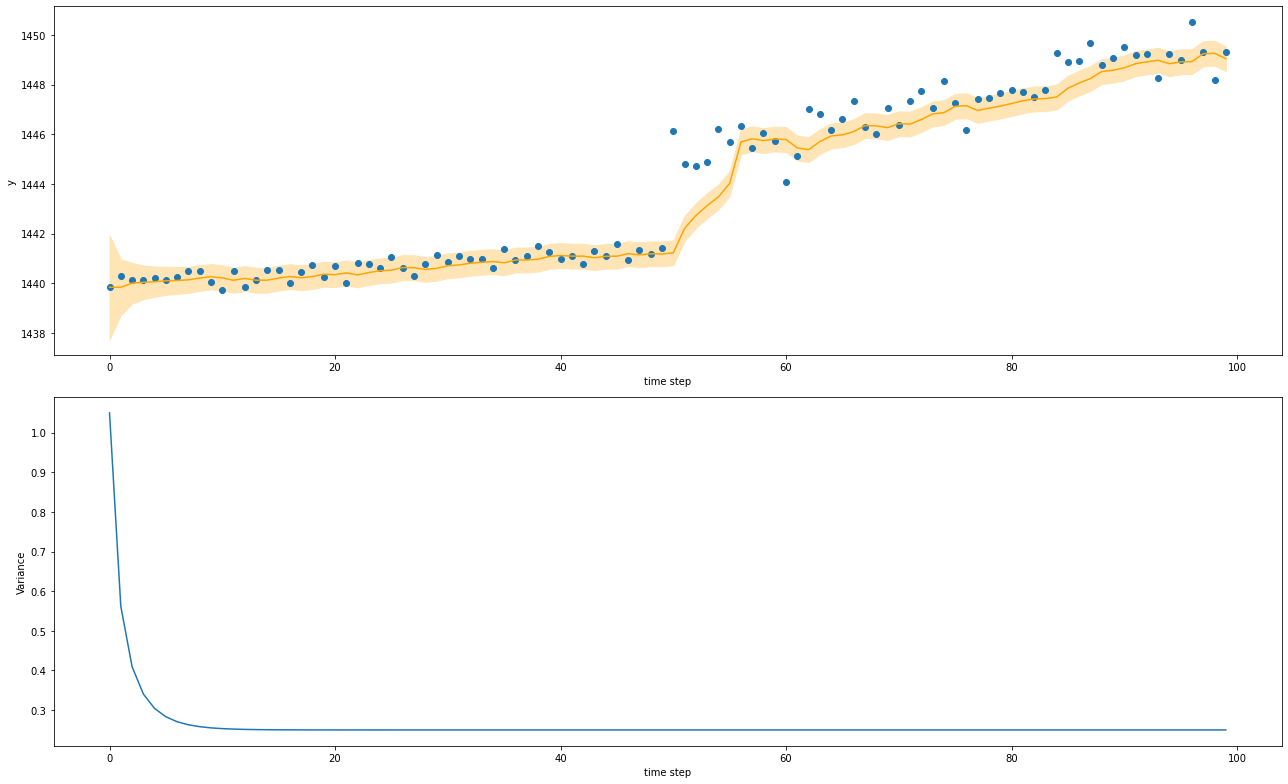

In [30]:
zs = sample.y
ts = sample.t
smoothing_param = 0.05
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)

# Clustering

# DP process clustering (failed, just for demonstration)

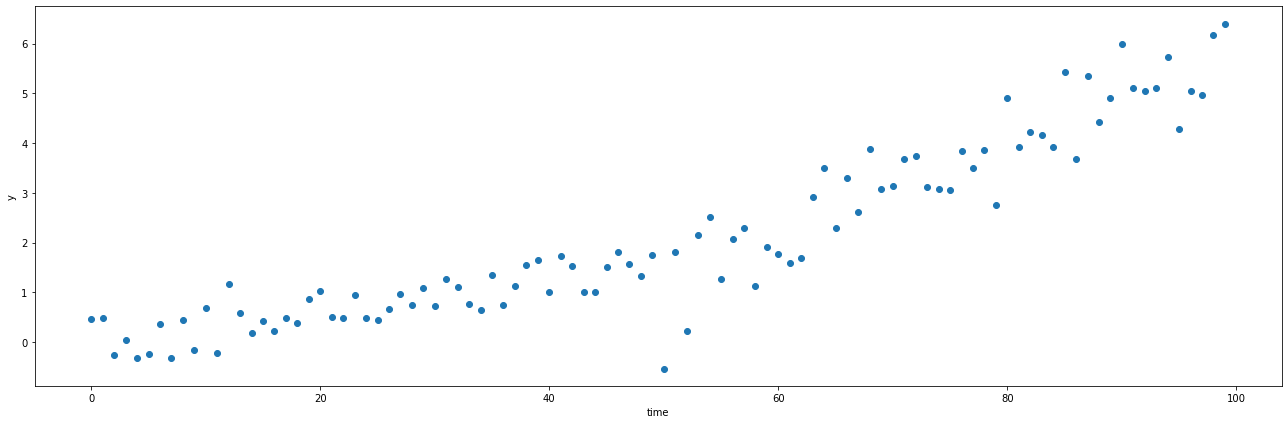

In [24]:
sample = Sample(N=50, mu=0, beta=0.03, sigma=0.3) + Sample(N=50, mu=1, beta=0.1, sigma=0.6)
sample.plot()
sample_data = [sample.y]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda_, tau, beta, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 46 seconds.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6808826123897134, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


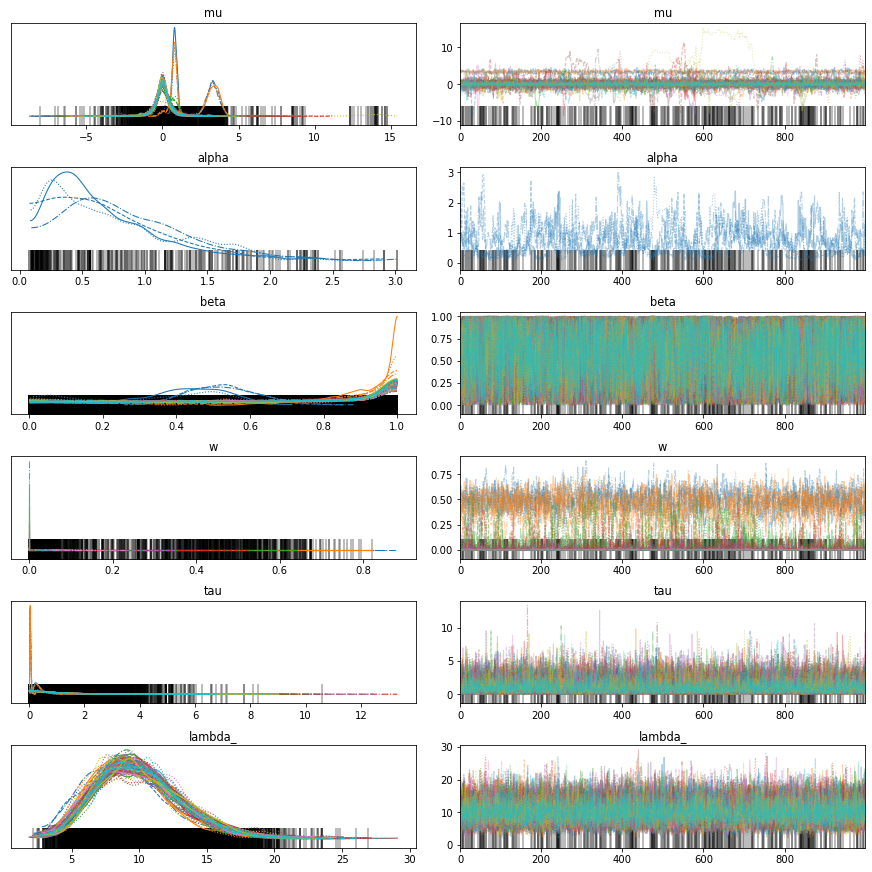

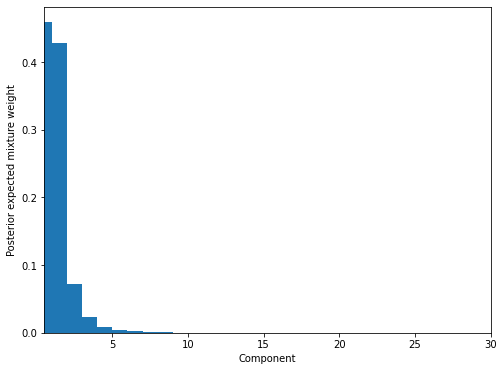

In [25]:
dp_model = DirchletProcessModel()
dp_model.fit(*sample_data)
dp_model.plot_trace()
dp_model.plot_num_cluster()

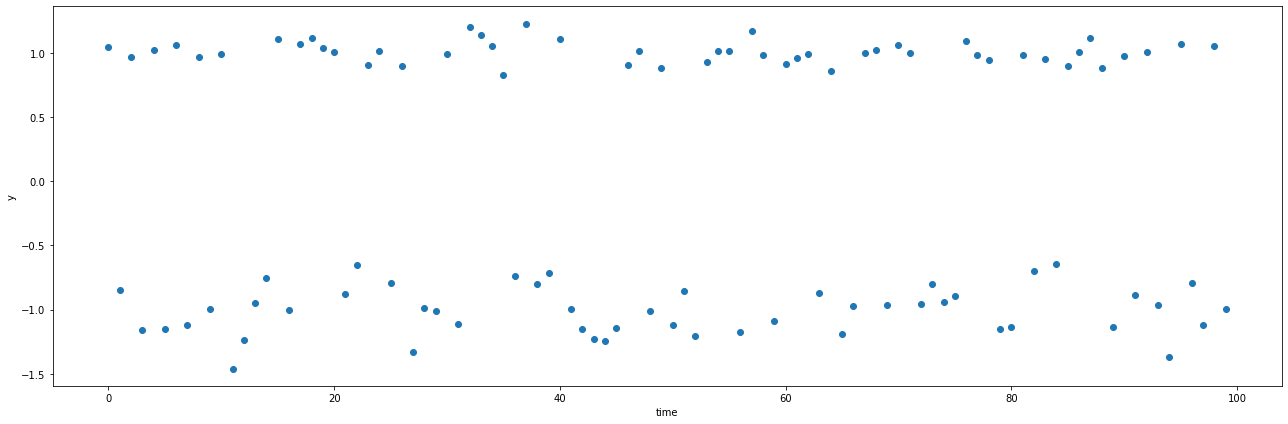

In [3]:
sample = Sample(N=50, mu=-1, beta=0, sigma=0.2) + Sample(N=50, mu=1, beta=0, sigma=0.1)
np.random.shuffle(sample.y)
sample.plot()
sample_data = [sample.y]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda_, tau, beta, alpha]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 51 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


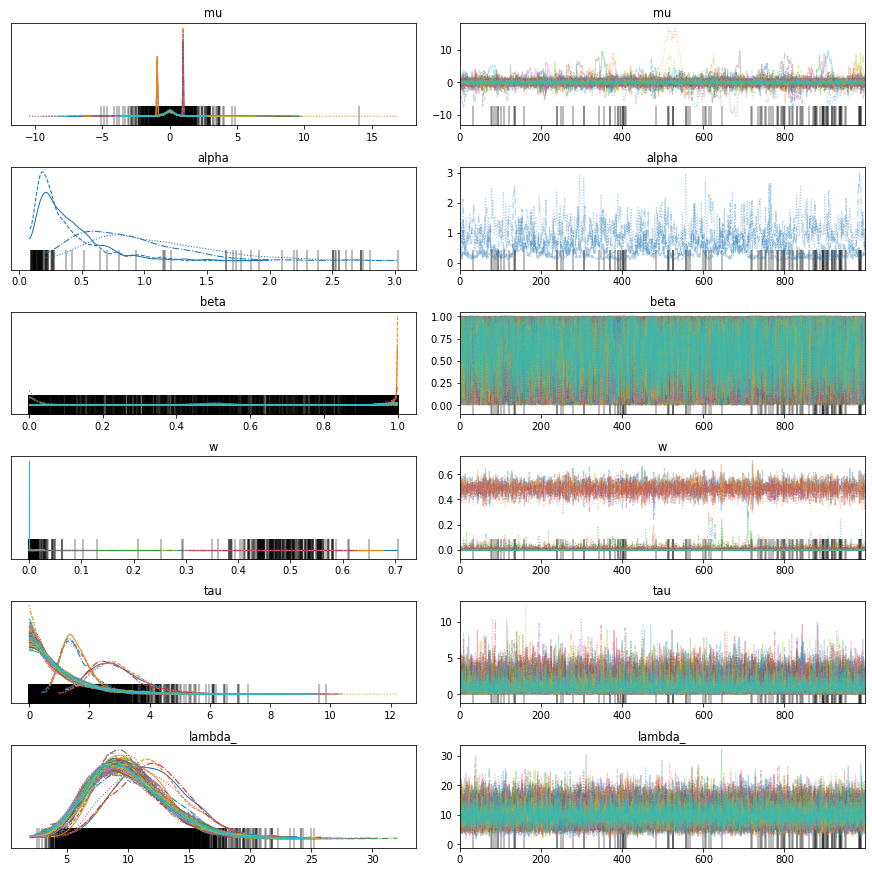

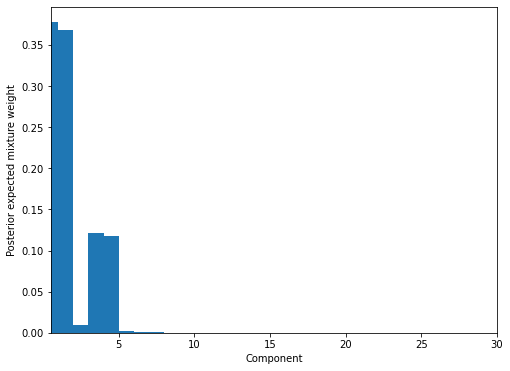

In [27]:
dp_model = DirchletProcessModel()
dp_model.fit(sample.y)
dp_model.plot_trace()
dp_model.plot_num_cluster()

# Gaussian Mixture clustering (Very good, but sensitive to outliers)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.


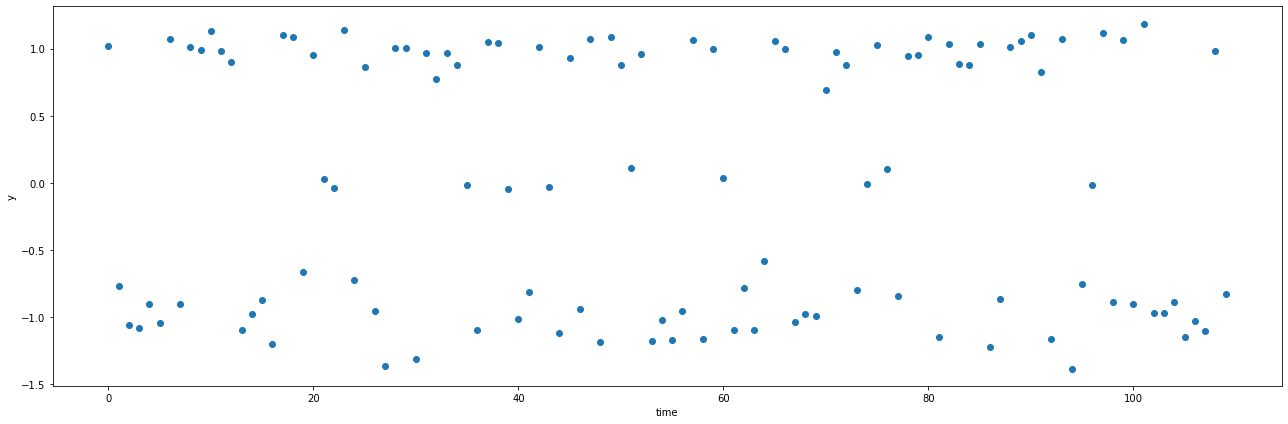

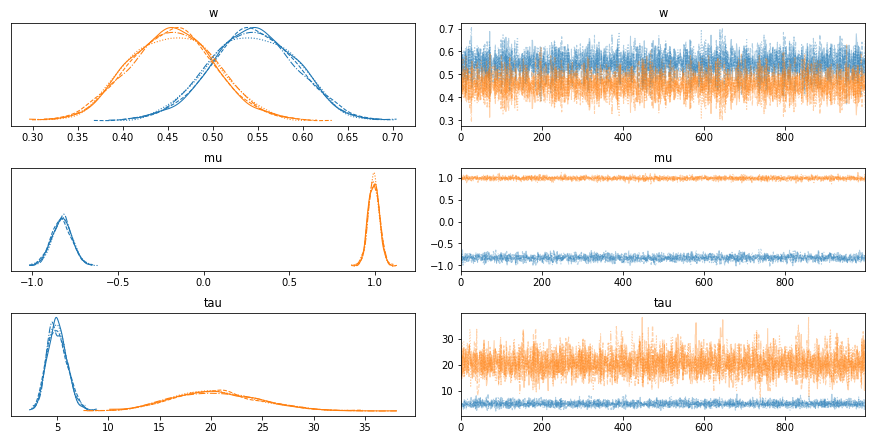

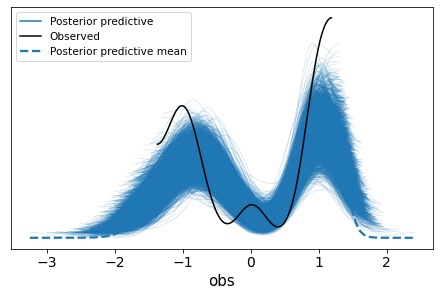

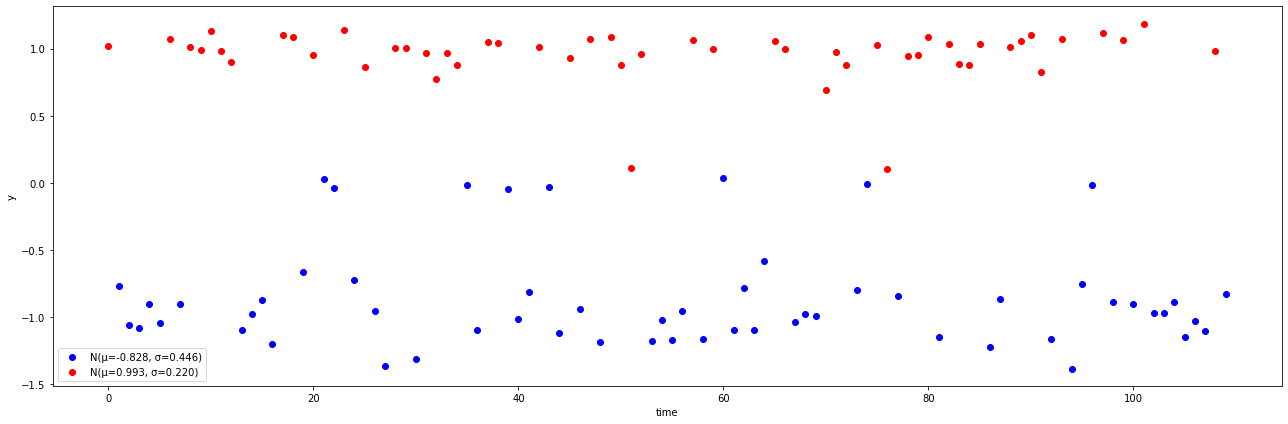

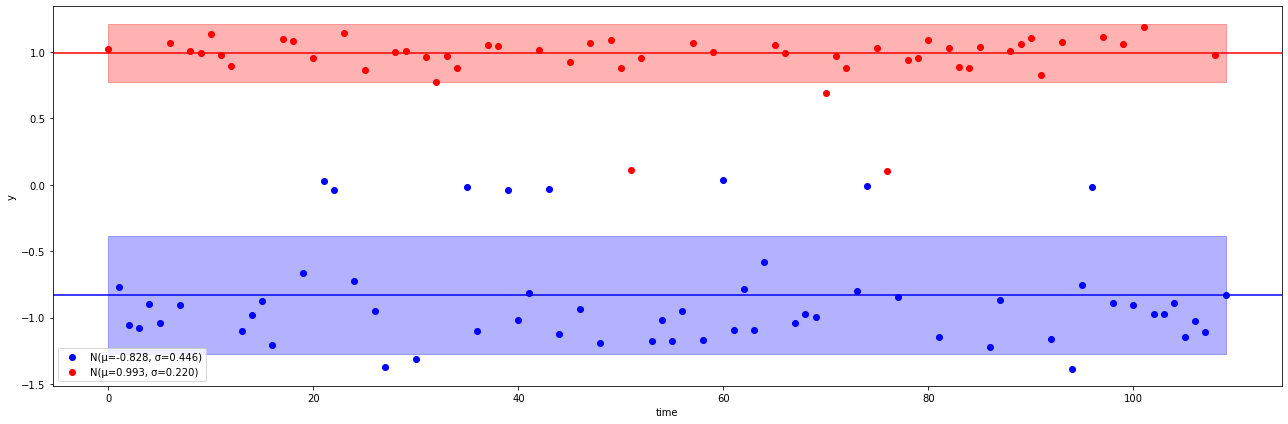

In [4]:
sample = Sample(N=50, mu=-1, beta=0, sigma=0.2) + Sample(N=50, mu=1, beta=0, sigma=0.1) + Sample(N=10, mu=0, beta=0, sigma=0.05)
np.random.shuffle(sample.y)
sample.plot()
gm_model = GaussianMixtureModel()
gm_model.fit(sample.y)
gm_model.plot_trace()
gm_model.plot_posterior_predictive()
gm_model.plot_cluster(sample.t, sample.y)
gm_model.plot_cluster_dist(sample.t, sample.y)


# StudentT Mixture clustering (Very very good, robust to outliers)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, tau, mu, w]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.


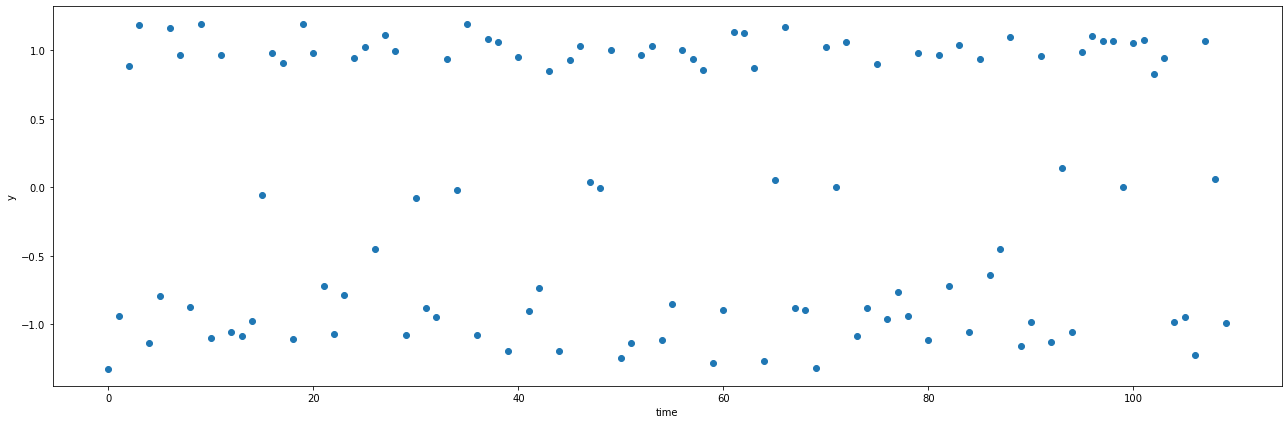

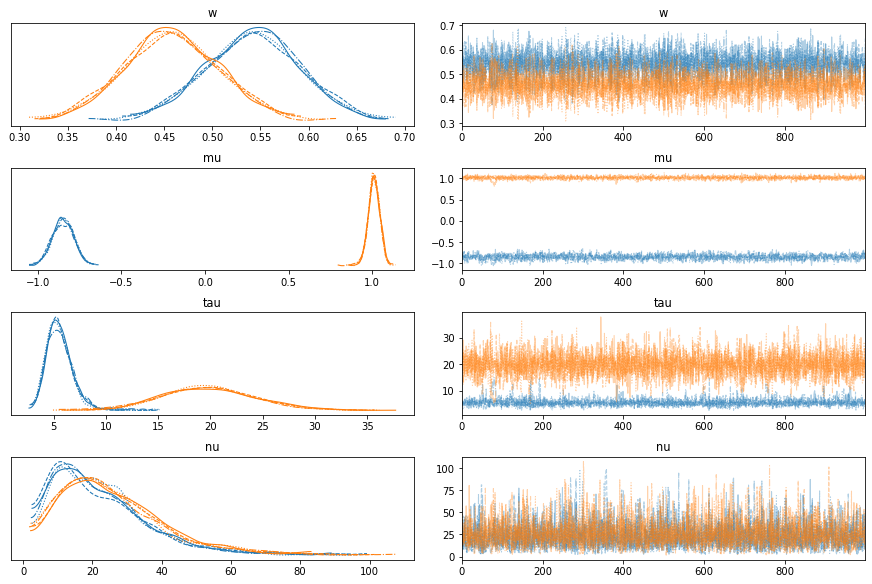

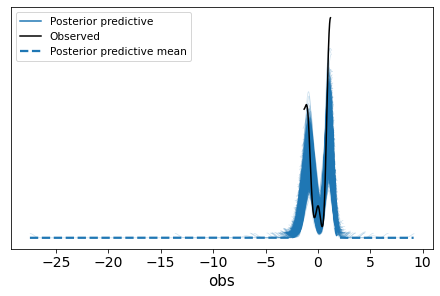

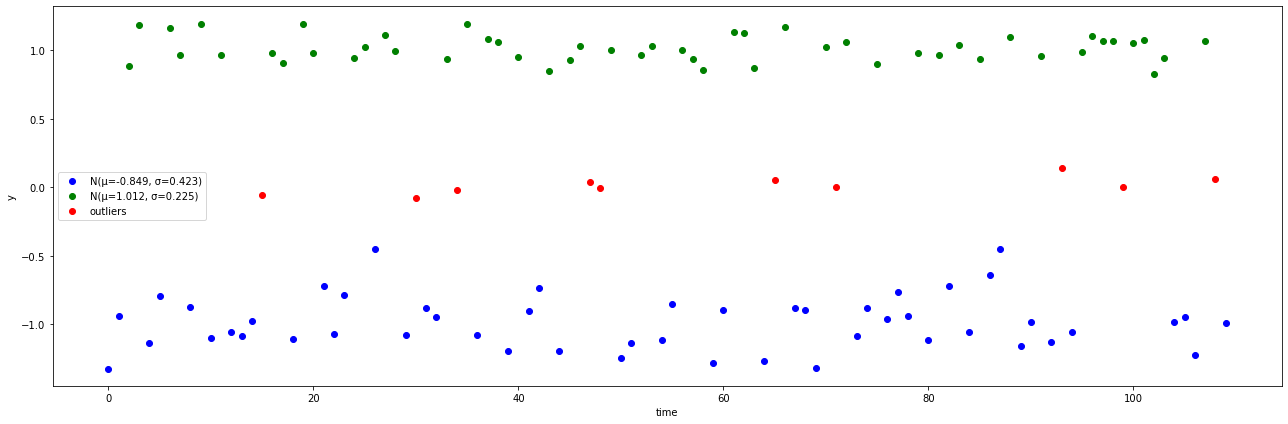

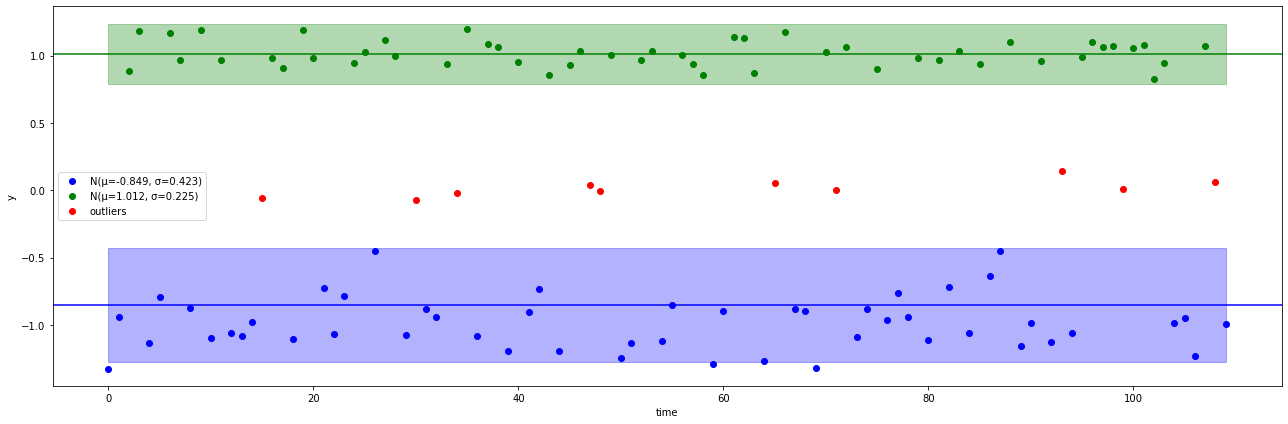

In [3]:
sample = Sample(N=50, mu=-1, beta=0, sigma=0.2) + Sample(N=50, mu=1, beta=0, sigma=0.1) + Sample(N=10, mu=0, beta=0, sigma=0.05)
np.random.shuffle(sample.y)
sample.plot()
t_model = TMixtureModel()
t_model.fit(sample.y)
t_model.plot_trace()
t_model.plot_posterior_predictive()
t_model.plot_cluster(sample.t, sample.y)
t_model.plot_cluster_dist(sample.t, sample.y)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, tau, mu, w]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 26 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8895523095716148, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


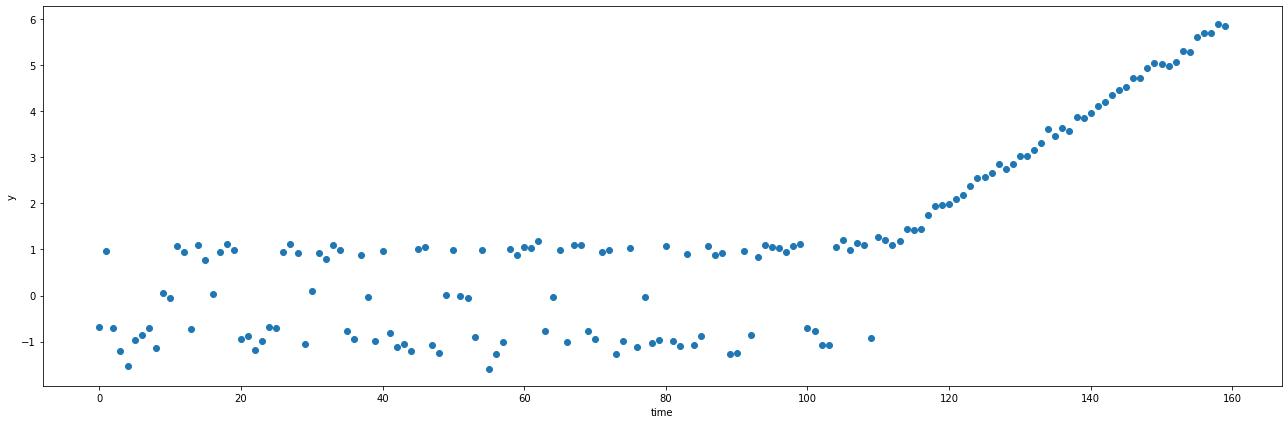

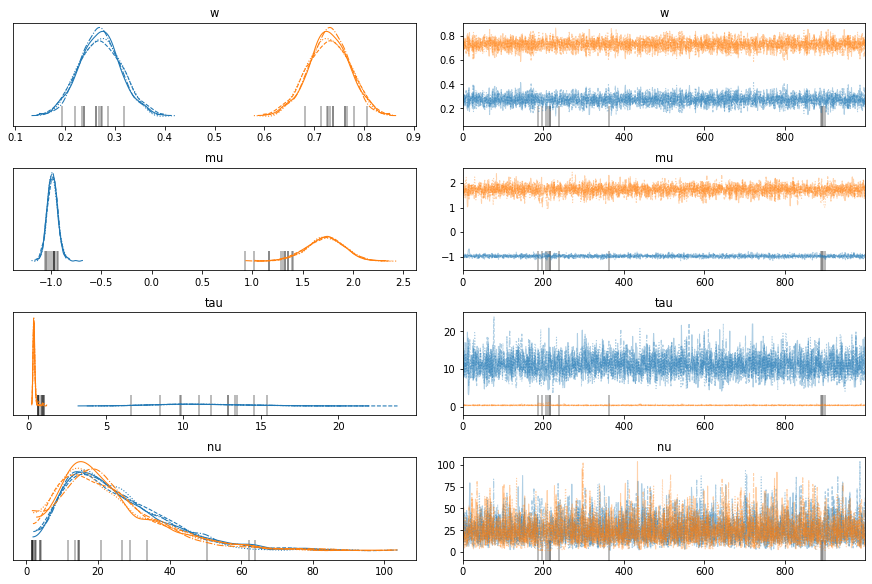

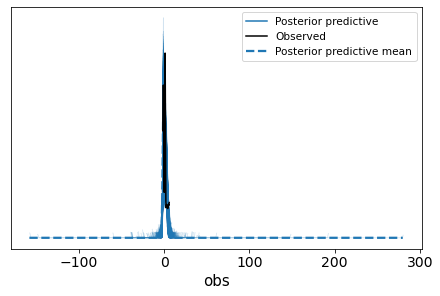

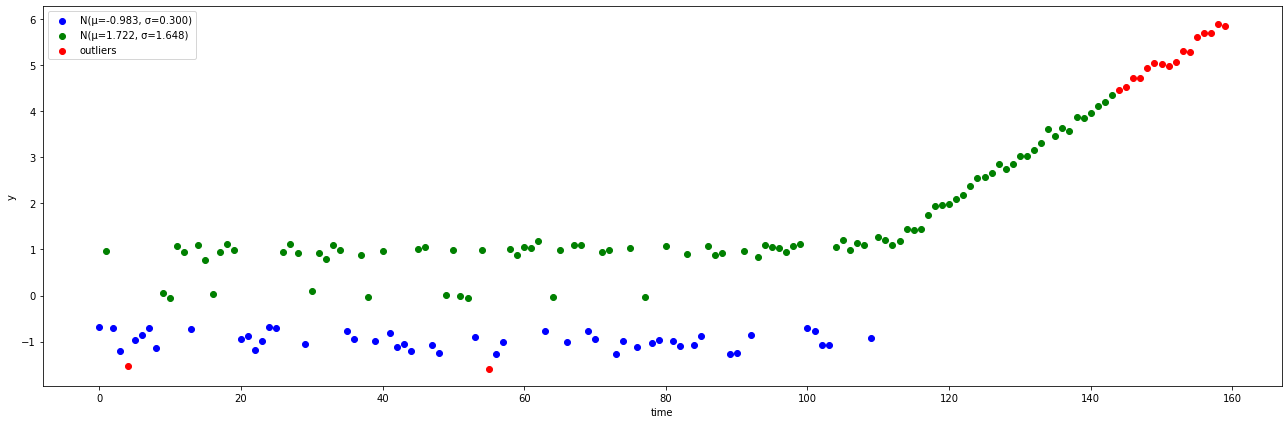

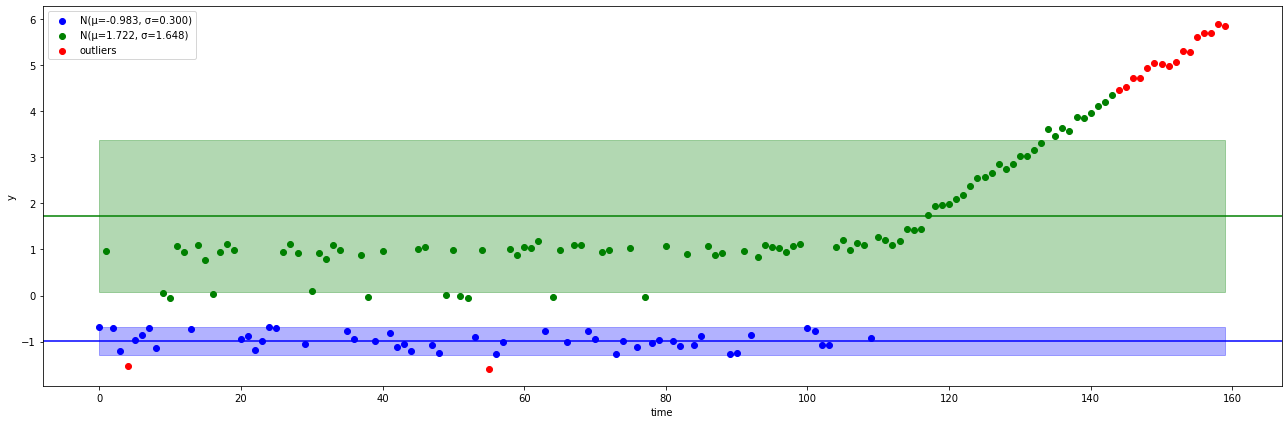

In [5]:
sample = Sample(N=50, mu=-1, beta=0, sigma=0.2) + Sample(N=50, mu=1, beta=0, sigma=0.1) + Sample(N=10, mu=0, beta=0, sigma=0.05)
np.random.shuffle(sample.y)
sample = sample + Sample(N=50, mu=1, beta=0.1, sigma=0.1)

sample.plot()
t_model = TMixtureModel()
t_model.fit(sample.y)
t_model.plot_trace()
t_model.plot_posterior_predictive()
t_model.plot_cluster(sample.t, sample.y)
t_model.plot_cluster_dist(sample.t, sample.y)


In [ ]:
7